In [1]:
import os
import json 
import getpass
from typing import List
from dataclasses import field
from langchain_ollama import ChatOllama
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

In [2]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama-deep-researcher-v2"

In [5]:
models = {
    "deepseek": "deepseek-r1:8b",
    "llama": "llama3.2:3b"
}

model = models['llama']

In [6]:
class GraphState(TypedDict):
    previous_queries: List[str] = field(default=None)
    query: str = field(default=None)
    topic: str = field(default=None)
    documents: List[str] = field(default=None)
    summary: str = field(default=None)
    search_loop_step: int = field(default=0)
    url_sources: List[str] = field(default=None)

In [7]:
def generate_query(state):
    print("-- Generating query --")
    prompt = """ Your goal is to generate targeted web search query.
        The query will gather information related to a specific topic.
        Topic: {topic}
        Return your query as a JSON object:
        {{
            "query": "string",
            "aspect": "string",
            "rationale": "string"
        }}"""
    
    prompt_formatted = prompt.format(topic=state['topic'])
    llm_json_mode = ChatOllama(model=model, temperature=0, format='json')
    response = llm_json_mode.invoke(prompt_formatted)
    query = json.loads(response.content)
    
    return {"query": query['query']} 
    

def web_research(state:GraphState):
    print("-- Starting Web Research --")
    web_search_tool = TavilySearchResults(k=3)
    
    documents = state.get("documents", [])
    url_sources = state.get('url_sources', [])
    
    
    
    docs = web_search_tool.invoke({'query': state['query']})
    web_results = "\n".join(d['content'] for d in docs)
    web_results = Document(page_content=web_results)      
    documents.append(web_results)
    for d in docs:
        url_sources.append(d['url'])
    
    return {'documents': documents, 'url_sources': url_sources}
    

def summarize_source(state:GraphState):

    prompt = """
    Your goal is to generate a high-quality summary of the web search results.

    When EXTENDING an existing summary:
    1. Seamlessly integrate new information without repeating what's already covered
    2. Maintain consistency with the existing content's style and depth
    3. Only add new, non-redundant information
    4. Ensure smooth transitions between existing and new content
    
    When creating a NEW summary:
    1. Highlight the most relevant information from each source
    2. Provide a concise overview of the key points related to the report topic
    3. Emphasize significant findings or insights
    4. Ensure a coherent flow of information
    
    CRITICAL REQUIREMENTS:
    - Start IMMEDIATELY with the summary content - no introductions or meta-commentary
    - DO NOT include ANY of the following:
      * Phrases about your thought process ("Let me start by...", "I should...", "I'll...")
      * Explanations of what you're going to do
      * Statements about understanding or analyzing the sources
      * Mentions of summary extension or integration
    - Focus ONLY on factual, objective information
    - Maintain a consistent technical depth
    - Avoid redundancy and repetition
    - DO NOT use phrases like "based on the new results" or "according to additional sources"
    - DO NOT add a References or Works Cited section
    - DO NOT use any XML-style tags like <think> or <answer>
    - Begin directly with the summary text without any tags, prefixes, or meta-commentary
    
    Summary:
    {summary}
    
    Documents retrieved from internet:
    {document}
    """
    
    doc = format_docs(state['documents'])
    summary = state.get('summary', 'Do not exist an summary, you need to create one')
    prompt_formatted = prompt.format(document=doc, summary=summary)
    
    
    llm = ChatOllama(model=model, temperature=0)
    summary = llm.invoke(prompt_formatted)
    return {"summary" : summary, "existing_summary": True}

def reflect_on_summary(state:GraphState):
    
    prompt = """
    You are a research optimization assistant. Analyze the current summary and generate one improved search query to fill information gaps the summary's topic is: {topic}
    
    Your tasks:
        1. Identify knowledge gaps or areas that need deeper exploration
        2. Generate a follow-up query that would help expand your understanding
        3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

    Ensure the follow-up question is self-contained and includes necessary context for web search.
    
    Summary:
    {summary}
    

    Return your query as a JSON object:
        {{
            "new_query": "string",
            "aspect": "string",
            "rationale": "string"
        }}"""
    
    summary = state['summary']
    topic = state['topic']
    prompt_formatted = prompt.format(summary=summary,
                                     topic=topic)
    
    previous_queries = state.get('previous_queries', [])
    current_query = state.get('query', None)
    previous_queries.append(current_query)
    
    llm_json_mode = ChatOllama(model=model, temperature=0, format='json')
    response = llm_json_mode.invoke(prompt_formatted)
    query = json.loads(response.content)
    query = query['new_query']
    search_loop_step = state.get('search_loop_step', 0)
    
    return {'query': query, 'search_loop_step': search_loop_step+1, 'previous_queries': previous_queries}

    
    
def finalize_summary(state:GraphState):
    print("--- CURRENT QUERY ---")
    print(state['query'])
    print("--- PREVIOUS QUERIES ---")
    print(state['previous_queries'])
    print("--- TOPIC ---")
    print(state['topic'])
    print("--- SUMMARY ---")
    print(state['summary'])
    print("--- URL SOURCES ---")
    print(state['url_sources'])

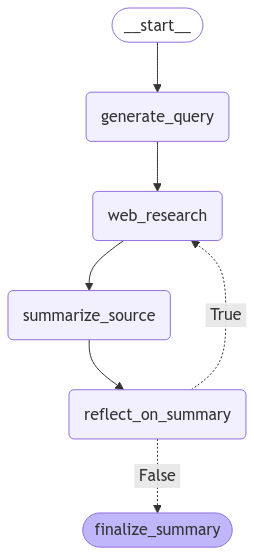

In [8]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)


workflow.add_node("generate_query", generate_query)
workflow.add_node("web_research", web_research)
workflow.add_node("summarize_source", summarize_source)
workflow.add_node("reflect_on_summary", reflect_on_summary)
workflow.add_node("finalize_summary", finalize_summary)

def loop_condition(state: GraphState):
    return state['search_loop_step'] < 3

workflow.set_entry_point("generate_query")

workflow.add_edge("generate_query", "web_research")  
workflow.add_edge("web_research", "summarize_source")
workflow.add_edge("summarize_source", "reflect_on_summary")

workflow.add_conditional_edges(
    "reflect_on_summary",
    loop_condition,
    {
        True: "web_research",  
        False: "finalize_summary",  
    },
)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
inputs = {"topic": "How does Chain of Thoughts works?"}

for event in graph.stream(inputs, stream_mode="values"):
    print(event)

{'topic': 'How does Chain of Thoughts works?'}
-- Generating query --
{'query': 'How does the chain of thoughts work in cognitive psychology?', 'topic': 'How does Chain of Thoughts works?'}
-- Starting Web Research --
{'query': 'How does the chain of thoughts work in cognitive psychology?', 'topic': 'How does Chain of Thoughts works?', 'documents': [Document(metadata={}, page_content='2 | Artificial Intelligence (AI) AI Use Cases: How is Tech Using Artificial Intelligence? Chain-of-thought reasoning is a powerful technique that enhances AI models\' cognitive abilities by breaking down complex tasks into smaller steps. This article introduces the latest development known as chain-of-thought (CoT) reasoning, a prompt-based technique that enables AI models to exhibit cognitive abilities. To address these challenges, chain-of-thought reasoning is a promising new technique specifically designed to enable AI models to successfully tackle these cognitive tasks. The use of chain-of-thought rea